## ch1

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2022.08.09 </div> 
<div style="text-align: right"> Last update: 2022.08.09</div> 

In [130]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
#import missingno as msno
import gc
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

# Options for pandas
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [131]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [132]:
def jointplots(xs, y, data, hue=None, height=6, ratio=5, space=0.2, xlabels=None, ylabel=None, margin_norm=False):
    """
    -------------------
    Input Parameters
    -------------------
    xs      : (list or str) feature name(s) of data
    y       : (str) feature name of data
    data    : (pandas.DataFrame)
    hue     : (str) semantic variable that is mapped to determine the color of plot elements. Semantic variable that is mapped to determine the color of plot elements.
    
    height  : (float) size of the figure
    ratio   : (float) ratio of the joint axes height to marginal axes height.
    space   : (float) space between the joint and marginal axes
    
    xlabels : (list or str) xlabels
    ylabel  : (str) ylabel
    margin_norm : (boolean) if True, kdeplots at marginal axes have same scale.
    """
    ### 1. input check
    # input type
    assert isinstance(xs, list) or isinstance(xs, str)
    if isinstance(xs, list):
        assert all([isinstance(x, str) for x in xs])
    else:
        xs = [xs]
        
    
    if xlabels != None:
        assert isinstance(xlabels, list) or isinstance(xlabels, str)
        if isinstance(xlabels, list):
            assert all([isinstance(xlabel, str) for xlabel in xlabels])
        else:
            xlabels = [xlabels]
    
    if ylabel != None:
        assert isinstance(ylabel, str)
    
    if hue != None:
        assert isinstance(hue, str)
    
    # input data
    assert all([x in data.columns for x in xs])
    assert y in data.columns
    if hue != None:
        assert hue in data.columns
    
    
    ### 2. figure
    h_margin = height / (ratio + 1)
    h_joint = height - h_margin
    
    if isinstance(xs, list):
        n_x = len(xs)
    else:
        n_x = 1
    
    widths = [h_joint] * n_x + [h_margin]
    heights = [h_margin, h_joint]
    ncols = len(widths)
    nrows = len(heights)
    
    fig = plt.figure(figsize=(sum(widths), sum(heights)))
    
    ### 3. gridspec preparation
    spec = fig.add_gridspec(ncols=ncols, nrows=nrows, 
                            width_ratios = widths, height_ratios = heights,
                            wspace=space, hspace=space
                           )
    
    ### 4. setting axes
    axs = {}
    for i in range(ncols * nrows):
        axs[i] = fig.add_subplot(spec[i//ncols, i%ncols])
    
    
    ### 5. jointplots (scatterplot + kdeplot)
    for i, x in enumerate(xs, ncols):
        if i == ncols:
            legend=True
        else:
            legend=False
        sns.kdeplot(x=x, y=y, data=data, hue=hue, alpha=0.3, ax=axs[i], zorder=2, legend=False)
        sns.scatterplot(x=x, y=y, data=data, hue=hue, alpha=0.8, ax=axs[i], zorder=3, legend=legend)
    
    
    ### 6. kdeplots at marginal axes
    axs[ncols-1].axis("off")
    
    axes_mx = list(range(ncols-1))
    axes_my = 2*ncols - 1
    
    for i, x in zip(axes_mx, xs):
        sns.kdeplot(x=x, data=data, hue=hue, fill=True, ax=axs[i], zorder=2, legend=False)
        axs[i].set_xlim(axs[i+ncols].get_xlim())
        axs[i].set_xlabel("")
        axs[i].set_xticklabels([])
        axs[i].spines["left"].set_visible(False)
        axs[i].spines["top"].set_visible(False)
        axs[i].spines["right"].set_visible(False)
    
    sns.kdeplot(y=y, data=data, hue=hue, fill=True, ax=axs[axes_my], zorder=2, legend=False)
    axs[axes_my].set_ylim(axs[ncols].get_ylim())
    axs[axes_my].set_ylabel("")
    axs[axes_my].set_yticklabels([])
    axs[axes_my].spines["bottom"].set_visible(False)
    axs[axes_my].spines["top"].set_visible(False)
    axs[axes_my].spines["right"].set_visible(False)
    
    if margin_norm == True:
        hist_range_max = max([axs[m].get_ylim()[-1] for m in axes_mx] + [axs[axes_my].get_xlim()[-1]])
        for i in axes_mx:
            axs[i].set_ylim(0, hist_range_max)
        axs[axes_my].set_xlim(0, hist_range_max)
        
        
    ### 7. unnecessary elements removal
    # 7.1. labels and ticklabels
    axes_j = list(range(ncols, 2*ncols-1))
    for i in axes_j:
        if i != ncols:
            axs[i].set_ylabel("")
            axs[i].set_yticklabels([])
    
    # 7.2. marginal axes
    for i in axes_mx:
        if i != 0:
            axs[i].set_ylabel("")
        
        axs[i].grid("on", color="lightgray", zorder=0)
        axs[i].set_yticklabels([])
        
        yticks = axs[i].get_yticks()
        ylim = axs[i].get_ylim()
        for ytick in yticks:
            if 0 < ytick < ylim[-1]:
                axs[i].text(axs[i].get_xlim()[0], ytick, str(ytick), 
                            fontdict={"verticalalignment":"center"})
        
    axs[axes_my].grid("on", color="lightgray", zorder=0)
    axs[axes_my].set_xticklabels([])
    axes_my_xticks = axs[axes_my].get_xticks()
    axes_my_xlim = axs[axes_my].get_xlim()
    for xtick in axes_my_xticks:
        if 0 < xtick < axes_my_xlim[-1]:
            axs[axes_my].text(xtick, axs[axes_my].get_ylim()[0], str(xtick), 
                              rotation=270, fontdict={"horizontalalignment":"center"})
    
    # 7.3. labels
    font_label = {"color": "gray", "fontsize":"large"}
    labelpad = 12
    for i, x in zip(axes_j, xlabels):
        axs[i].set_xlabel(x, fontdict=font_label, labelpad=labelpad)
        if i == ncols:
            axs[i].set_ylabel(ylabel, fontdict=font_label, labelpad=labelpad)
    
    axs[0].set_ylabel("Density", fontdict=font_label, labelpad=labelpad)
    axs[2*ncols-1].set_xlabel("Density", fontdict=font_label, labelpad=labelpad)
    
    fig.align_ylabels([axs[0], axs[ncols]])
    fig.align_xlabels([axs[x] for x in range(ncols, 2*ncols)])
    plt.tight_layout()
    
    return fig, axs

In [133]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

### 1. 고객정보

In [134]:
user = pd.read_csv('lifelog/GB_SVC_USER.csv', encoding='CP949')

In [135]:
user.shape

(11240, 61)

In [136]:
user.head()

,USER_ID,PJT_NO,NICK_NM,USER_EMAIL,USER_NM,MNBR_NTRY_SE_CD,UUID,TOKEN,REFRESH_TOKEN,USER_MOBILE,BIRTHDAY,GENDER,TALL,WEIGHT,OS,REGISTRATION_ID,APP_VER_NO,PUSH_ID,PROFILE_FILE,SNS_PROFILE_URL,LEAVE_DT,POINT,LEAVE_REASON,STATUS,VER_NO,REG_DT,FIREBASE_UID,SIGNUP_DT,AUTH_INFO,RECOMM_MOBILE,OS_VER,MOBILE_BRAND,MOBILE_MODEL,BLOCK_DT,BLOCK_REASON,SMS_AGREE,SMS_AGREE_DT,LAST_LOGIN_DT,PERSONAL_INFO_AGREE,EVT_DC_INFO_AGREE,PERSONAL_INFO_AGREE_DT,EVT_DC_INFO_AGREE_DT,PUSH_AGREE,PUSH_AGREE_DT,EMAIL_AGREE,EMAIL_AGREE_DT,SSN6,SSN1,RECMD_CD,RECMD_ID,WEB_ROLE,COMP_CD,COMP_TOKEN,CODE_PUSH_NO,APP_VER_UPD_DT,PWD,COMMENT,APP_SCREEN_AUTH_NO,CI,PROFIL_OPEN_YN,DI
0,3,1,hhh,sangmin.han@gi-vita.io,NaN,G,0c1w7RhB7uSlPUKa9mPhfeP7Xh32,eyJ0eXBlIjoiSldUIiwicmVnRGF0ZSI6MTY0NjYyOTM4MD...,eyJ0eXBlIjoiSldUIiwicmVnRGF0ZSI6MTY0NjYyOTM4MD...,010-5254-8226,20030707.0,M,175.0,65.0,A,6fa0c91ad962bb06,1.6.1,dgSB2xHJSO6TF4Z5eTanDG:APA91bGOn9O-ssNjseaS3aP...,NaN,NaN,NaN,0,NaN,정상,43,2021-12-29 13:28:27.000,0c1w7RhB7uSlPUKa9mPhfeP7Xh32,2021-10-26 16:53:20.000,NaN,NaN,NaN,NaN,LM-V500N,NaN,NaN,Y,NaN,2022-03-07 14:03:00.000,N,N,NaN,NaN,Y,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,GIVITA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,4,1,유히,yuhee.park@gi-vita.io,NaN,G,wrGlBlnlK4QiZO9So3seFL9F5Yk2,eyJ0eXBlIjoiSldUIiwicmVnRGF0ZSI6MTY0MjM4NTU5Mz...,eyJ0eXBlIjoiSldUIiwicmVnRGF0ZSI6MTY0MjM4NTU5Mz...,010-4187-7998,20051130.0,F,168.0,57.0,A,e7e23699746bcec2,1.5.7,dHi2BECrRZieuo6rLwaphn:APA91bF2nEAWDgeiYJWf7vM...,NaN,NaN,NaN,1000,NaN,정상,3,2021-12-29 13:28:27.000,wrGlBlnlK4QiZO9So3seFL9F5Yk2,2021-10-26 16:55:57.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,2022-01-17 11:13:13.000,N,N,NaN,NaN,Y,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,GIVITA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,5,1,june0tst,juneyoung.bae@gi-vita.io,NaN,G,XlpF8Oz6kAfTveHaEzeXfeF7z3C2,NaN,NaN,010-2399-3025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-08 16:25:27.000,2000,NaN,탈퇴,11,2021-12-29 13:28:27.000,XlpF8Oz6kAfTveHaEzeXfeF7z3C2,2021-10-26 16:57:05.000,NaN,NaN,NaN,NaN,SM-N960N,NaN,NaN,Y,NaN,2022-02-08 15:02:00.000,N,N,NaN,NaN,Y,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,GIVITA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,7,1,채효,ks960427@gmail.com,NaN,G,ViMxJ9UMmZV0ASe9h2uvWb9Klei1,eyJ0eXBlIjoiSldUIiwicmVnRGF0ZSI6MTY1OTM0MTQ5ND...,eyJ0eXBlIjoiSldUIiwicmVnRGF0ZSI6MTY1ODEwMDczND...,010-8971-6536,19690917.0,M,183.7,85.4,A,6da0f6d1c39c3f33,1.6.32,f0cFyHwbSZiky7rlO3hpAj:APA91bHMa2bNQhHoAXgw7i1...,NaN,NaN,NaN,0,NaN,정상,477,2021-12-29 13:28:27.000,ViMxJ9UMmZV0ASe9h2uvWb9Klei1,2021-10-26 17:07:36.000,NaN,NaN,NaN,NaN,SM-G977N,NaN,NaN,Y,NaN,2022-08-02 07:23:01.000,N,N,NaN,NaN,Y,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,GIVITA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4,10,1,hamin,khm0651@naver.com,NaN,G,a47qlgI78ibovj3ZzEvg7t7nydr2,eyJ0eXBlIjoiSldUIiwicmVnRGF0ZSI6MTY1OTMyOTE2MT...,eyJ0eXBlIjoiSldUIiwicmVnRGF0ZSI6MTY1OTMyOTE2MT...,010-4938-0651,20030101.0,M,178.8,72.2,A,e85c3dea1df106b6,1.6.32,eNFCzlr-RLqhkJw2eWHVm0:APA91bHBvQaJtjLLcKi9zcM...,NaN,NaN,NaN,0,NaN,정상,245,2021-12-29 13:28:27.000,a47qlgI78ibovj3ZzEvg7t7nydr2,2021-10-26 17:37:27.000,NaN,NaN,NaN,NaN,SM-S906N,NaN,NaN,Y,NaN,2022-08-01 13:46:01.000,N,N,NaN,NaN,Y,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,GIVITA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN


In [137]:
user.columns

Index(['USER_ID', 'PJT_NO', 'NICK_NM', 'USER_EMAIL', 'USER_NM',
       'MNBR_NTRY_SE_CD', 'UUID', 'TOKEN', 'REFRESH_TOKEN', 'USER_MOBILE',
       'BIRTHDAY', 'GENDER', 'TALL', 'WEIGHT', 'OS', 'REGISTRATION_ID',
       'APP_VER_NO', 'PUSH_ID', 'PROFILE_FILE', 'SNS_PROFILE_URL', 'LEAVE_DT',
       'POINT', 'LEAVE_REASON', 'STATUS', 'VER_NO', 'REG_DT', 'FIREBASE_UID',
       'SIGNUP_DT', 'AUTH_INFO', 'RECOMM_MOBILE', 'OS_VER', 'MOBILE_BRAND',
       'MOBILE_MODEL', 'BLOCK_DT', 'BLOCK_REASON', 'SMS_AGREE', 'SMS_AGREE_DT',
       'LAST_LOGIN_DT', 'PERSONAL_INFO_AGREE', 'EVT_DC_INFO_AGREE',
       'PERSONAL_INFO_AGREE_DT', 'EVT_DC_INFO_AGREE_DT', 'PUSH_AGREE',
       'PUSH_AGREE_DT', 'EMAIL_AGREE', 'EMAIL_AGREE_DT', 'SSN6', 'SSN1',
       'RECMD_CD', 'RECMD_ID', 'WEB_ROLE', 'COMP_CD', 'COMP_TOKEN',
       'CODE_PUSH_NO', 'APP_VER_UPD_DT', 'PWD', 'COMMENT',
       'APP_SCREEN_AUTH_NO', 'CI', 'PROFIL_OPEN_YN', 'DI'],
      dtype='object')

In [138]:
user = user[['USER_ID', 'NICK_NM', 'USER_EMAIL', 'USER_NM', 'USER_MOBILE', 'BIRTHDAY', 'GENDER', 
             'TALL', 'WEIGHT', 'OS', 'APP_VER_NO', 'STATUS']]

In [139]:
user

,USER_ID,NICK_NM,USER_EMAIL,USER_NM,USER_MOBILE,BIRTHDAY,GENDER,TALL,WEIGHT,OS,APP_VER_NO,STATUS
0,3,hhh,sangmin.han@gi-vita.io,NaN,010-5254-8226,20030707.0,M,175.0,65.0,A,1.6.1,정상
1,4,유히,yuhee.park@gi-vita.io,NaN,010-4187-7998,20051130.0,F,168.0,57.0,A,1.5.7,정상
2,5,june0tst,juneyoung.bae@gi-vita.io,NaN,010-2399-3025,NaN,NaN,NaN,NaN,NaN,NaN,탈퇴
3,7,채효,ks960427@gmail.com,NaN,010-8971-6536,19690917.0,M,183.7,85.4,A,1.6.32,정상
4,10,hamin,khm0651@naver.com,NaN,010-4938-0651,20030101.0,M,178.8,72.2,A,1.6.32,정상
...,...,...,...,...,...,...,...,...,...,...,...,...
11235,11632,도화걷기머신,kill716@daum.net,권태형,01044474835,19940420.0,M,173.0,60.0,Android,1.6.32,정상
11236,11633,경은이,nicegg76@hanmail.net,김재수,01099074110,19761126.0,M,167.0,60.0,Android,1.6.32,정상
11237,11634,떠아사랑해,ejsvk3600@gmail.com,김선희,01088042583,19671025.0,F,155.0,60.0,Android,1.6.32,정상
11238,11635,타키온,hwang92303@gmail.com,황현지,01041903324,19990619.0,F,166.0,60.0,Android,1.6.32,정상


상태가 정상인 가입자만 추출

In [140]:
user = user[user['STATUS']=='정상']

In [146]:
user.head(10000)[8900:8906]

,USER_ID,NICK_NM,USER_EMAIL,USER_NM,USER_MOBILE,BIRTHDAY,GENDER,TALL,WEIGHT,OS,APP_VER_NO,STATUS
9168,9561,TH,60gks@hanmail.net,한태희,01025284696,19600821.0,M,167.5,60.0,Android,1.6.31,정상
9169,9562,돈콩돈콩,85may21@naver.com,백경환,01047729756,19850521.0,M,172.0,60.0,Android,1.6.31,정상
9170,9563,뿌에엥,seulmin.moon@gmail.com,문슬민,01031858624,19880817.0,F,164.6,60.0,Android,1.6.29,정상
9171,9564,동2,bigmaum3@naver.com,신동이,01077225487,19721220.0,M,176.0,60.0,Android,1.6.31,정상
9172,9565,진짜히어로,akito4@naver.com,이경운,01046641284,19850102.0,M,174.0,60.0,Android,1.6.31,정상
9173,9566,부평왕족발,csn4167@gmail.com,최수남,01048141608,19640705.0,M,172.5,60.0,Android,1.6.29,정상


In [142]:
user.shape

(10920, 12)

In [147]:
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10920 entries, 0 to 11239
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   USER_ID      10920 non-null  int64  
 1   NICK_NM      10920 non-null  object 
 2   USER_EMAIL   10920 non-null  object 
 3   USER_NM      9598 non-null   object 
 4   USER_MOBILE  10919 non-null  object 
 5   BIRTHDAY     10920 non-null  float64
 6   GENDER       10920 non-null  object 
 7   TALL         10920 non-null  float64
 8   WEIGHT       10920 non-null  float64
 9   OS           10919 non-null  object 
 10  APP_VER_NO   10918 non-null  object 
 11  STATUS       10920 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 1.1+ MB


생년월일 데이터 전처리 : 나이 계산 위해

In [148]:
birthday = user['BIRTHDAY'].astype('str')
user['BIRTHDAY'] = birthday.str[:4] +'-' + birthday.str[4:6]+'-' + birthday.str[6:8]
user['BIRTHDAY'] = pd.to_datetime(user['BIRTHDAY'])
user.head()

,USER_ID,NICK_NM,USER_EMAIL,USER_NM,USER_MOBILE,BIRTHDAY,GENDER,TALL,WEIGHT,OS,APP_VER_NO,STATUS
0,3,hhh,sangmin.han@gi-vita.io,NaN,010-5254-8226,2003-07-07,M,175.0,65.0,A,1.6.1,정상
1,4,유히,yuhee.park@gi-vita.io,NaN,010-4187-7998,2005-11-30,F,168.0,57.0,A,1.5.7,정상
3,7,채효,ks960427@gmail.com,NaN,010-8971-6536,1969-09-17,M,183.7,85.4,A,1.6.32,정상
4,10,hamin,khm0651@naver.com,NaN,010-4938-0651,2003-01-01,M,178.8,72.2,A,1.6.32,정상
5,11,korea5214,korea5214@gmail.com,NaN,010-4065-4685,2003-04-19,M,177.0,79.5,A,1.0.2,정상


In [149]:
user['AGE'] = datetime.datetime.today().year - user['BIRTHDAY'].dt.year
user.head(10000)[8900:8906]

,USER_ID,NICK_NM,USER_EMAIL,USER_NM,USER_MOBILE,BIRTHDAY,GENDER,TALL,WEIGHT,OS,APP_VER_NO,STATUS,AGE
9168,9561,TH,60gks@hanmail.net,한태희,01025284696,1960-08-21,M,167.5,60.0,Android,1.6.31,정상,62
9169,9562,돈콩돈콩,85may21@naver.com,백경환,01047729756,1985-05-21,M,172.0,60.0,Android,1.6.31,정상,37
9170,9563,뿌에엥,seulmin.moon@gmail.com,문슬민,01031858624,1988-08-17,F,164.6,60.0,Android,1.6.29,정상,34
9171,9564,동2,bigmaum3@naver.com,신동이,01077225487,1972-12-20,M,176.0,60.0,Android,1.6.31,정상,50
9172,9565,진짜히어로,akito4@naver.com,이경운,01046641284,1985-01-02,M,174.0,60.0,Android,1.6.31,정상,37
9173,9566,부평왕족발,csn4167@gmail.com,최수남,01048141608,1964-07-05,M,172.5,60.0,Android,1.6.29,정상,58


In [122]:
user.shape

(10920, 13)

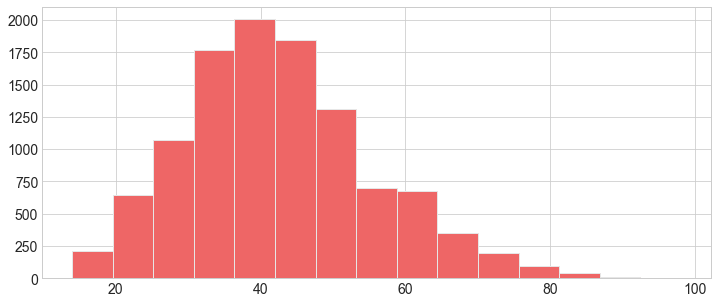

In [164]:
ax = user['AGE'].hist(figsize = (12, 5), bins = 15, edgecolor='#E6E6E6', color='#EE6666')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [165]:
user['AGE'].mean()

42.45668498168498

만 25세 이하를 청년, 58세 미만을 성인, 그 이상을 시니어로 구분  

In [166]:
user['GROUP'] = user['AGE'].apply(lambda x: 'youth' if x < 26 else ('adult' if x < 58 else 'elderly'))

In [167]:
user.head(10000)[8900:8906]

,USER_ID,NICK_NM,USER_EMAIL,USER_NM,USER_MOBILE,BIRTHDAY,GENDER,TALL,WEIGHT,OS,APP_VER_NO,STATUS,AGE,GROUP
9168,9561,TH,60gks@hanmail.net,한태희,01025284696,1960-08-21,M,167.5,60.0,Android,1.6.31,정상,62,elderly
9169,9562,돈콩돈콩,85may21@naver.com,백경환,01047729756,1985-05-21,M,172.0,60.0,Android,1.6.31,정상,37,adult
9170,9563,뿌에엥,seulmin.moon@gmail.com,문슬민,01031858624,1988-08-17,F,164.6,60.0,Android,1.6.29,정상,34,adult
9171,9564,동2,bigmaum3@naver.com,신동이,01077225487,1972-12-20,M,176.0,60.0,Android,1.6.31,정상,50,adult
9172,9565,진짜히어로,akito4@naver.com,이경운,01046641284,1985-01-02,M,174.0,60.0,Android,1.6.31,정상,37,adult
9173,9566,부평왕족발,csn4167@gmail.com,최수남,01048141608,1964-07-05,M,172.5,60.0,Android,1.6.29,정상,58,elderly


In [168]:
user['GROUP'].value_counts()

adult      8569
elderly    1496
youth       855
Name: GROUP, dtype: int64

<AxesSubplot:>

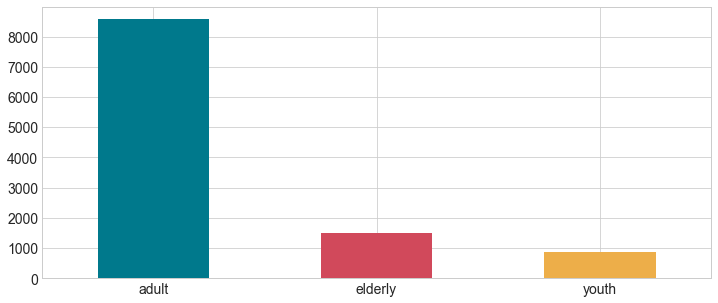

In [170]:
user['GROUP'].value_counts().plot(kind = 'bar', figsize = (12, 5), color=colors, fontsize = 14, rot = 0)

In [171]:
user.to_csv('lifelog/GB_SVC_USER_processed.csv', index=False, encoding='CP949')

### 2. 일별 걸음 데이터

In [172]:
step = pd.read_csv('lifelog/GB_BYDT_STEP.csv')

In [173]:
step.head()

,USER_ID,MSRE_DTM,STEP_CNT,MOVE_DIST,CNPT_CALR,MOVE_SPEED,FRST_REG_DTM,FRST_REG_USER_NO,FRST_REG_PGM_ID,LST_CHG_DTM,LST_CHG_USER_NO,LST_CHG_PGM_ID,WALK_SCORE
0,4,2021-10-26 00:00:00.000,5417.0,4104.298828,204.639999,1.429030,2021-10-27 08:04:30.000,NaN,NaN,NaN,NaN,NaN,0
1,3,2021-10-27 00:00:00.000,110.0,83.983040,4.258073,1.354610,2021-11-06 11:27:53.000,NaN,NaN,NaN,NaN,NaN,0
2,4,2021-10-27 00:00:00.000,5455.0,4152.960938,200.949982,1.453837,2021-10-28 10:04:02.000,NaN,NaN,NaN,NaN,NaN,0
3,5,2021-10-27 00:00:00.000,4918.0,3757.562744,197.159180,1.430885,2021-10-28 07:49:24.000,NaN,NaN,NaN,NaN,NaN,0
4,7,2021-10-27 00:00:00.000,5980.0,4739.403320,302.210968,1.557562,2021-10-28 12:08:44.000,NaN,NaN,NaN,NaN,NaN,0


In [174]:
step.shape

(188140, 13)

In [175]:
step.columns

Index(['USER_ID', 'MSRE_DTM', 'STEP_CNT', 'MOVE_DIST', 'CNPT_CALR',
       'MOVE_SPEED', 'FRST_REG_DTM', 'FRST_REG_USER_NO', 'FRST_REG_PGM_ID',
       'LST_CHG_DTM', 'LST_CHG_USER_NO', 'LST_CHG_PGM_ID', 'WALK_SCORE'],
      dtype='object')

In [176]:
step = step[['MSRE_DTM', 'USER_ID', 'STEP_CNT', 'MOVE_DIST', 'CNPT_CALR', 'MOVE_SPEED']]

In [177]:
step.head()

,MSRE_DTM,USER_ID,STEP_CNT,MOVE_DIST,CNPT_CALR,MOVE_SPEED
0,2021-10-26 00:00:00.000,4,5417.0,4104.298828,204.639999,1.429030
1,2021-10-27 00:00:00.000,3,110.0,83.983040,4.258073,1.354610
2,2021-10-27 00:00:00.000,4,5455.0,4152.960938,200.949982,1.453837
3,2021-10-27 00:00:00.000,5,4918.0,3757.562744,197.159180,1.430885
4,2021-10-27 00:00:00.000,7,5980.0,4739.403320,302.210968,1.557562


In [178]:
step['MSRE_DTM'] = pd.to_datetime(step['MSRE_DTM'])

In [179]:
step.head()

,MSRE_DTM,USER_ID,STEP_CNT,MOVE_DIST,CNPT_CALR,MOVE_SPEED
0,2021-10-26,4,5417.0,4104.298828,204.639999,1.429030
1,2021-10-27,3,110.0,83.983040,4.258073,1.354610
2,2021-10-27,4,5455.0,4152.960938,200.949982,1.453837
3,2021-10-27,5,4918.0,3757.562744,197.159180,1.430885
4,2021-10-27,7,5980.0,4739.403320,302.210968,1.557562


In [180]:
step.tail()

,MSRE_DTM,USER_ID,STEP_CNT,MOVE_DIST,CNPT_CALR,MOVE_SPEED
188135,2022-08-02,11626,150.0,97.539999,4.440000,0.977520
188136,2022-08-02,11631,6704.0,5123.590001,267.949984,1.411110
188137,2022-08-02,11632,27.0,19.950000,1.390000,1.107110
188138,2022-08-02,11633,59.0,41.600003,2.260000,1.104627
188139,2022-08-02,11636,490.0,397.819993,15.490000,2.046290


In [42]:
step.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188140 entries, 0 to 188139
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   MSRE_DTM    188140 non-null  datetime64[ns]
 1   USER_ID     188140 non-null  int64         
 2   STEP_CNT    188140 non-null  float64       
 3   MOVE_DIST   188140 non-null  float64       
 4   CNPT_CALR   188140 non-null  float64       
 5   MOVE_SPEED  188140 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 8.6 MB


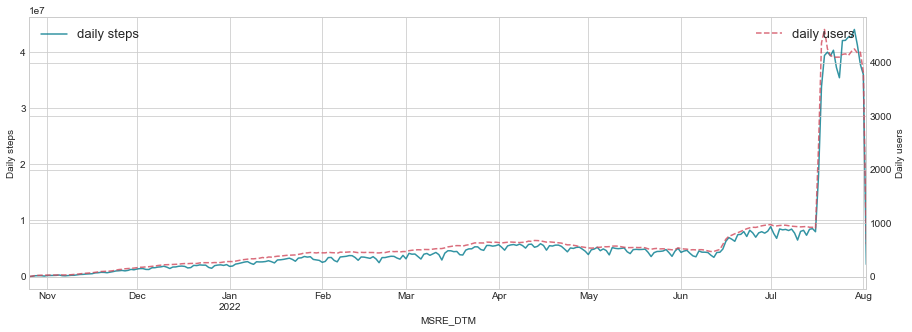

In [183]:
fig, ax1 = plt.subplots(figsize = (15, 5))
ax2 = ax1.twinx()
step[['MSRE_DTM', 'STEP_CNT']].set_index('MSRE_DTM').resample('D').sum()['STEP_CNT']\
                                .plot(ax =ax1, color=colors[0], label = 'daily steps', alpha = 0.8)
step[['MSRE_DTM', 'USER_ID']].set_index('MSRE_DTM').resample('D').count()['USER_ID']\
                                .plot(ax =ax2, color=colors[1], label = 'daily users', alpha = 0.8, style = '--')
ax1.set_ylabel('Daily steps')
ax2.set_ylabel('Daily users')
ax1.legend(loc=0, fontsize = 13)
ax2.legend(loc=1, fontsize = 13)
plt.show()

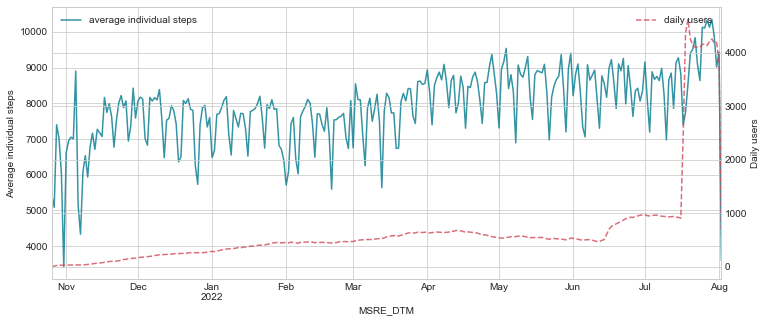

In [50]:
fig, ax1 = plt.subplots(figsize = (12, 5))
ax2 = ax1.twinx()
step[['MSRE_DTM', 'STEP_CNT']].set_index('MSRE_DTM').resample('D').mean()['STEP_CNT']\
                                .plot(ax =ax1, color=colors[0], label = 'average individual steps', alpha = 0.8)
step[['MSRE_DTM', 'USER_ID']].set_index('MSRE_DTM').resample('D').count()['USER_ID']\
                                .plot(ax =ax2, color=colors[1], label = 'daily users', alpha = 0.8, style = '--')
ax1.set_ylabel('Average individual steps')
ax2.set_ylabel('Daily users')
ax1.legend(loc=0)
ax2.legend(loc=1)
plt.show()

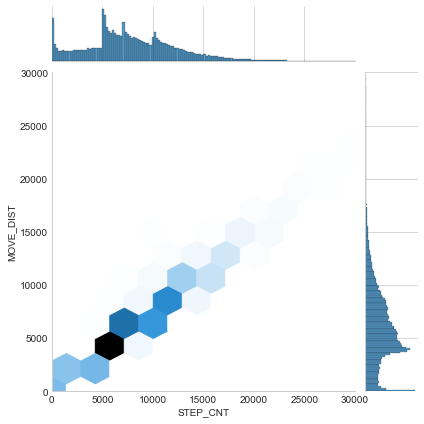

In [47]:
sns.jointplot(step['STEP_CNT'], step['MOVE_DIST'], kind='hex', xlim=(0,30000), ylim=(0,30000))

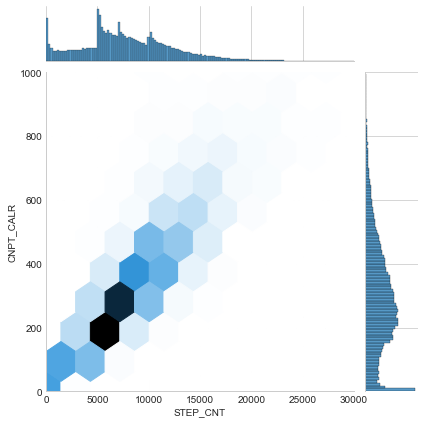

In [48]:
sns.jointplot(step['STEP_CNT'], step['CNPT_CALR'], kind='hex', xlim=(0,30000), ylim=(0,1000))

(<Figure size 1056x576 with 6 Axes>,
 {0: <AxesSubplot:ylabel='Density'>,
  1: <AxesSubplot:>,
  2: <AxesSubplot:>,
  3: <AxesSubplot:xlabel='move distance', ylabel='steps'>,
  4: <AxesSubplot:xlabel='calrories'>,
  5: <AxesSubplot:xlabel='Density'>})

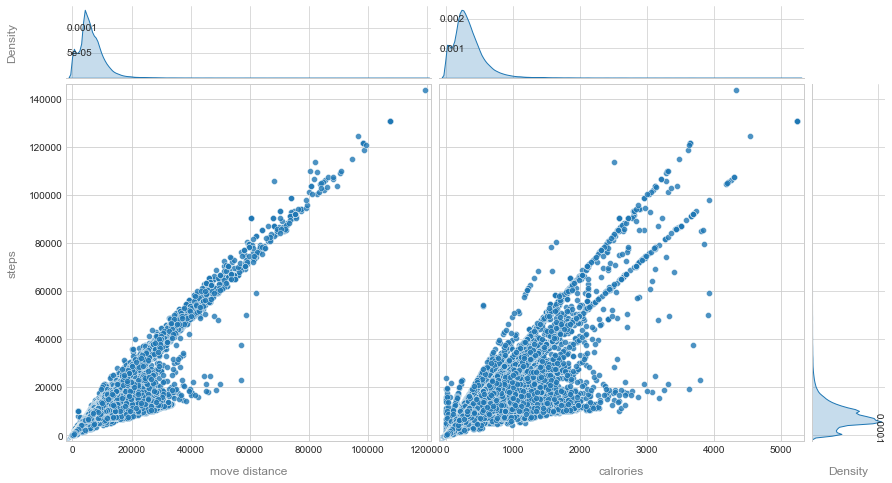

In [49]:
jointplots(['MOVE_DIST', 'CNPT_CALR'], 'STEP_CNT', step, height=8, ratio=5, space=0.03,
          xlabels = ['move distance', 'calrories'], ylabel = 'steps')

In [51]:
del step
gc.collect()

12102

### 3. 시간대별 걸음 데이터

In [52]:
step = pd.read_csv('lifelog/GB_STEP_HIST.csv')

데이터 메모리 최적화

In [53]:
step = reduce_mem_usage(step)

Memory usage of dataframe is 3151.05 MB
Memory usage after optimization is: 2115.68 MB
Decreased by 32.9%


In [54]:
step.shape

(25813411, 16)

In [55]:
step.columns

Index(['MSRE_BEGIN_DTM', 'MSRE_END_DTM', 'USER_ID', 'DVIC_TP', 'STEP_CNT',
       'MOVE_DIST', 'CNPT_CALR', 'MOVE_SPEED', 'WATCH_WEAR_LC_CD',
       'FRST_REG_DTM', 'FRST_REG_USER_NO', 'FRST_REG_PGM_ID', 'LST_CHG_DTM',
       'LST_CHG_USER_NO', 'LST_CHG_PGM_ID', 'DEVICE_GROUP'],
      dtype='object')

In [56]:
step = step[['MSRE_BEGIN_DTM', 'USER_ID', 'DVIC_TP', 'STEP_CNT', 'MOVE_DIST', 'CNPT_CALR', 'MOVE_SPEED']]

In [57]:
step['MSRE_BEGIN_DTM'] = step['MSRE_BEGIN_DTM'].astype('object')
step['MSRE_BEGIN_DTM'] = pd.to_datetime(step['MSRE_BEGIN_DTM'])

In [58]:
step.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25813411 entries, 0 to 25813410
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   MSRE_BEGIN_DTM  datetime64[ns]
 1   USER_ID         int16         
 2   DVIC_TP         category      
 3   STEP_CNT        int16         
 4   MOVE_DIST       float32       
 5   CNPT_CALR       float32       
 6   MOVE_SPEED      float32       
dtypes: category(1), datetime64[ns](1), float32(3), int16(2)
memory usage: 615.4 MB


In [59]:
step.head()

,MSRE_BEGIN_DTM,USER_ID,DVIC_TP,STEP_CNT,MOVE_DIST,CNPT_CALR,MOVE_SPEED
0,2022-01-04 19:44:00,317,WATCH,6,4.00,6.00,1.111111
1,2022-01-05 20:44:00,317,WATCH,6,4.00,6.00,1.111111
2,2022-01-31 00:01:00,210,360003,11,8.47,0.39,1.500000
3,2022-01-31 00:01:00,233,360003,1,0.83,0.04,2.138889
4,2022-01-31 00:01:00,274,360001,18,13.59,0.74,1.284435


In [60]:
step[step[['MSRE_BEGIN_DTM', 'USER_ID']].duplicated(keep=False)]

,MSRE_BEGIN_DTM,USER_ID,DVIC_TP,STEP_CNT,MOVE_DIST,CNPT_CALR,MOVE_SPEED
9,2022-01-31 00:01:00,464,360001,97,70.699997,5.060000,1.178333
10,2022-01-31 00:01:00,464,360003,106,78.483742,5.369317,1.308062
16,2022-01-31 00:01:00,581,360001,89,68.379997,3.560000,1.361111
17,2022-01-31 00:01:00,581,360003,83,65.669998,3.290000,1.388889
21,2022-01-31 00:01:00,691,360001,110,74.589989,5.500001,1.418392
...,...,...,...,...,...,...,...
25813395,2022-07-20 09:01:00,2163,360003,14,9.390000,0.420000,1.138889
25813397,2022-07-20 09:01:00,2613,360001,114,87.040001,5.700000,1.450667
25813398,2022-07-20 09:01:00,2613,360003,107,82.440002,5.240000,1.444444
25813405,2022-07-20 09:02:00,2613,360001,117,90.110001,5.850000,1.501833


In [61]:
step.sort_values(by='STEP_CNT', ascending=False).drop_duplicates(subset=['MSRE_BEGIN_DTM', 'USER_ID'], 
                                                                 keep='first').sort_index().head(30)

,MSRE_BEGIN_DTM,USER_ID,DVIC_TP,STEP_CNT,MOVE_DIST,CNPT_CALR,MOVE_SPEED
0,2022-01-04 19:44:00,317,WATCH,6,4.000000,6.000000,1.111111
1,2022-01-05 20:44:00,317,WATCH,6,4.000000,6.000000,1.111111
2,2022-01-31 00:01:00,210,360003,11,8.470000,0.390000,1.500000
3,2022-01-31 00:01:00,233,360003,1,0.830000,0.040000,2.138889
4,2022-01-31 00:01:00,274,360001,18,13.590000,0.740000,1.284435
5,2022-01-31 00:01:00,288,360001,9,6.440000,0.340000,1.333333
6,2022-01-31 00:01:00,327,360001,31,23.549999,1.800000,1.361111
7,2022-01-31 00:01:00,352,360003,11,7.670000,0.420000,1.166667
8,2022-01-31 00:01:00,426,360003,35,24.030001,1.350000,1.250000
10,2022-01-31 00:01:00,464,360003,106,78.483742,5.369317,1.308062


두개의 디바이스에서 중복으로 집계된 걸음은 큰 값을 선택

In [62]:
step = step.sort_values(by='STEP_CNT', 
                        ascending=False).drop_duplicates(subset=['MSRE_BEGIN_DTM', 'USER_ID'], 
                                                                 keep='first').sort_index()

In [63]:
step.shape

(18387580, 7)

In [64]:
gc.collect()

0

In [65]:
step[(step['MSRE_BEGIN_DTM']>= pd.to_datetime('2022-01-01 00:00:00'))&(step['MSRE_BEGIN_DTM']< pd.to_datetime('2022-07-12 00:01:00'))]

,MSRE_BEGIN_DTM,USER_ID,DVIC_TP,STEP_CNT,MOVE_DIST,CNPT_CALR,MOVE_SPEED
0,2022-01-04 19:44:00,317,WATCH,6,4.000000,6.000000,1.111111
1,2022-01-05 20:44:00,317,WATCH,6,4.000000,6.000000,1.111111
2,2022-01-31 00:01:00,210,360003,11,8.470000,0.390000,1.500000
3,2022-01-31 00:01:00,233,360003,1,0.830000,0.040000,2.138889
4,2022-01-31 00:01:00,274,360001,18,13.590000,0.740000,1.284435
...,...,...,...,...,...,...,...
23169433,2022-07-12 00:00:00,2644,360003,63,43.840000,1.300000,1.388889
23169435,2022-07-12 00:00:00,2646,360003,112,86.879997,5.040000,1.448000
23169436,2022-07-12 00:00:00,2654,360003,15,11.160000,0.760000,1.333333
23169438,2022-07-12 00:00:00,2661,360003,78,52.540077,4.979973,1.100621


2022-02-01 ~ 07-10 기간의 데이터만 추출

In [67]:
step = step[(step['MSRE_BEGIN_DTM']>= pd.to_datetime('2022-02-01'))]

In [68]:
step = step[(step['MSRE_BEGIN_DTM']<= pd.to_datetime('2022-07-10 23:55:00'))]

걸음 집계가 많은 상위 1500명의 ID만 추출

In [70]:
step['USER_ID'].value_counts()[:1500]

522     64293
737     51660
1060    50273
218     47860
341     47769
        ...  
2197     2958
2541     2952
1944     2950
2452     2948
2343     2945
Name: USER_ID, Length: 1500, dtype: int64

In [75]:
active_users = step['USER_ID'].value_counts()[:1500].index.tolist()

활성 유저의 걸음 정보만 추출

In [76]:
step = step[step['USER_ID'].isin(active_users)]

In [77]:
gc.collect()

1001

개인별 평균 걸음수/분

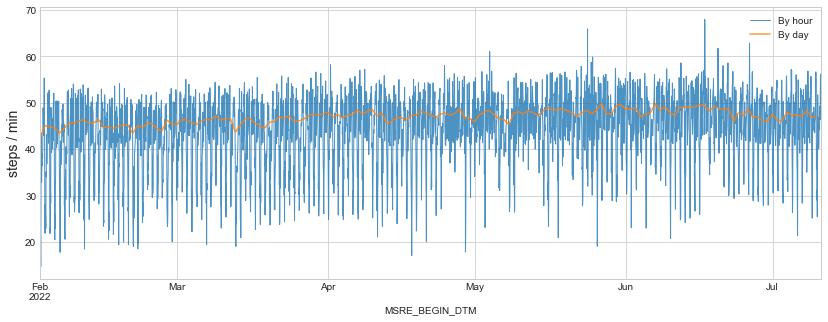

In [81]:
fig, ax = plt.subplots(figsize = (14, 5))
step[['MSRE_BEGIN_DTM', 'STEP_CNT']].set_index('MSRE_BEGIN_DTM').resample('H').mean()['STEP_CNT'].plot(ax=ax, linewidth = 1, 
                                    label = 'By hour', alpha = 0.8).set_ylabel('steps / min', fontsize= 14)
step[['MSRE_BEGIN_DTM', 'STEP_CNT']].set_index('MSRE_BEGIN_DTM').resample('D').mean()['STEP_CNT'].plot(ax=ax,
                                    label = 'By day', alpha = 0.8).set_ylabel('steps / min', fontsize= 14)
ax.legend()

활성 유저의 시간대, 일별 걸음수 합계

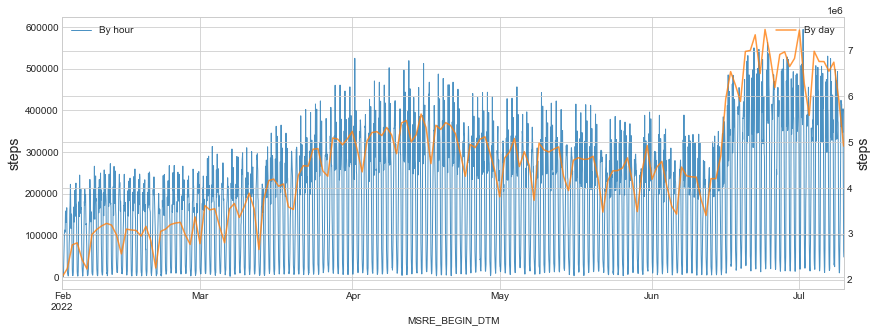

In [82]:
fig, ax1 = plt.subplots(figsize = (14, 5))
ax2 = ax1.twinx()
step[['MSRE_BEGIN_DTM', 'STEP_CNT']].set_index('MSRE_BEGIN_DTM').resample('H').sum()['STEP_CNT'].plot(ax=ax1, linewidth=1,
                                    label = 'By hour', color='tab:blue', alpha = 0.8).set_ylabel('steps', fontsize= 14)
step[['MSRE_BEGIN_DTM', 'STEP_CNT']].set_index('MSRE_BEGIN_DTM').resample('D').sum()['STEP_CNT'].plot(ax=ax2,
                                    label = 'By day', color='tab:orange', alpha = 0.8).set_ylabel('steps', fontsize= 14)
ax1.legend(loc=0)
ax2.legend(loc=1)

<AxesSubplot:xlabel='MSRE_BEGIN_DTM'>

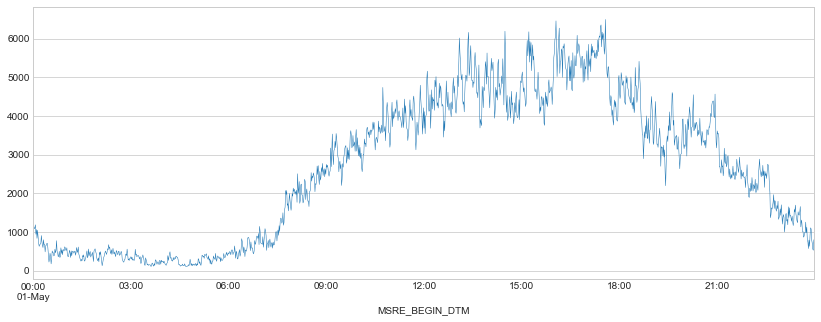

In [81]:
step[['MSRE_BEGIN_DTM', 'STEP_CNT']].set_index('MSRE_BEGIN_DTM').resample('1min').sum()['STEP_CNT'].loc['2022-05-01'].plot(figsize = (14, 5), linewidth = 0.5)

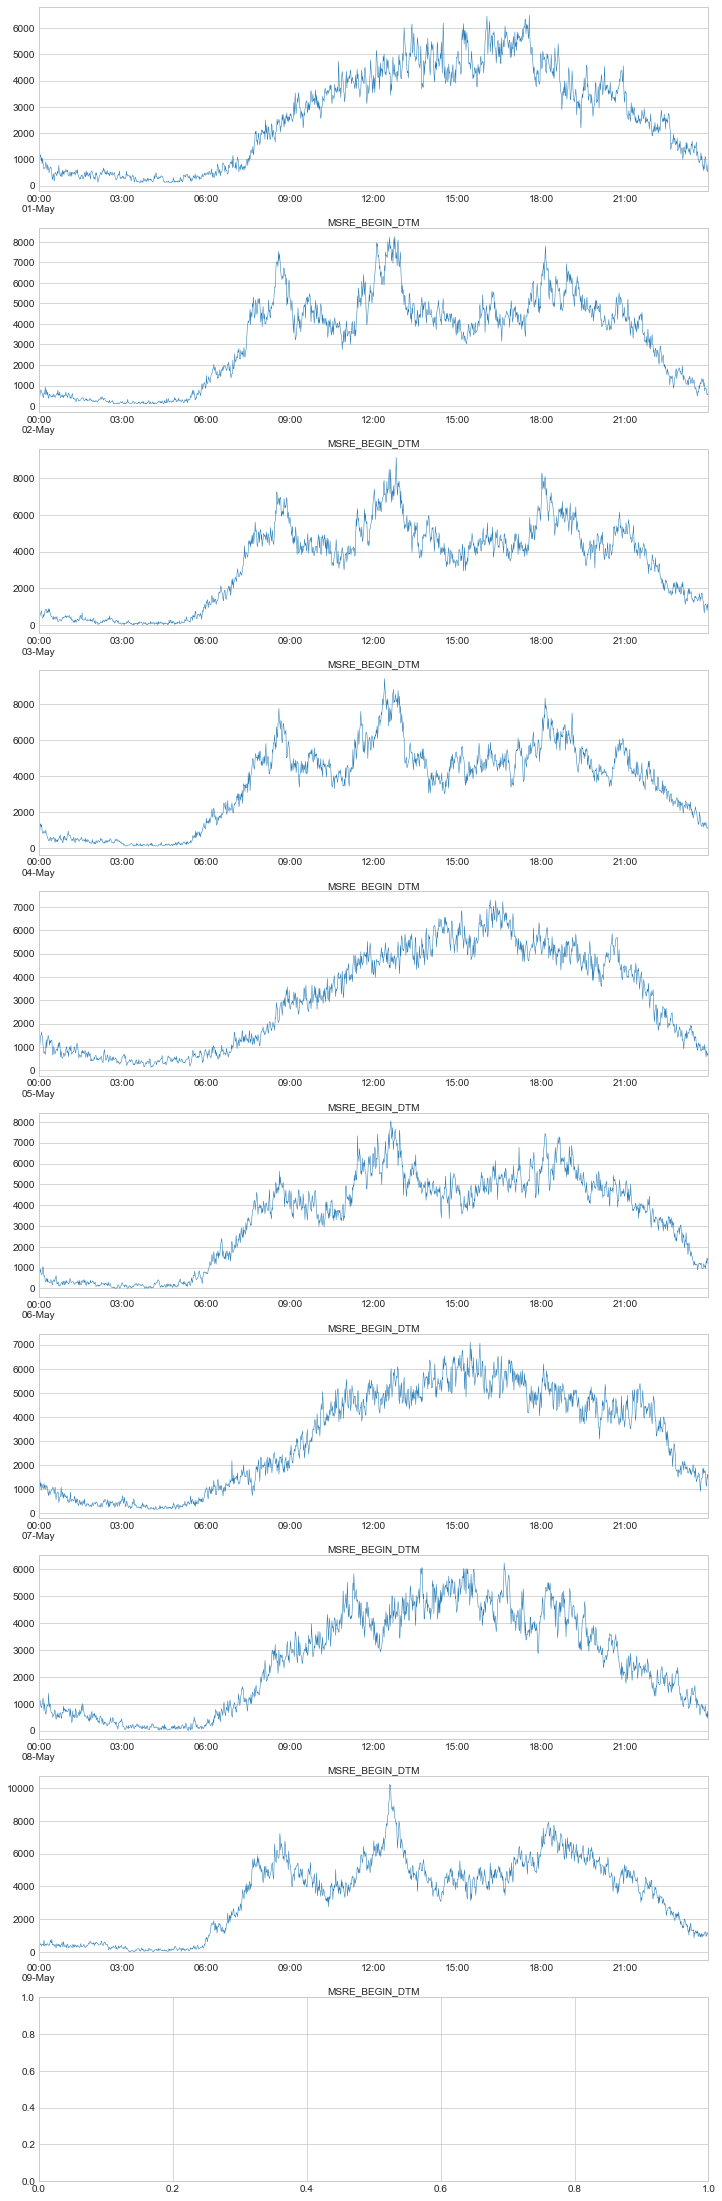

In [82]:
fig, axes = plt.subplots(10, 1,figsize = (12, 40))
for i in range(1, 10):
    date = f'2022-05-0{i}'
    step[['MSRE_BEGIN_DTM', 'STEP_CNT']].set_index('MSRE_BEGIN_DTM').resample('1min').sum()['STEP_CNT'].\
                loc[date].plot(ax = axes[i-1], linewidth = 0.5)

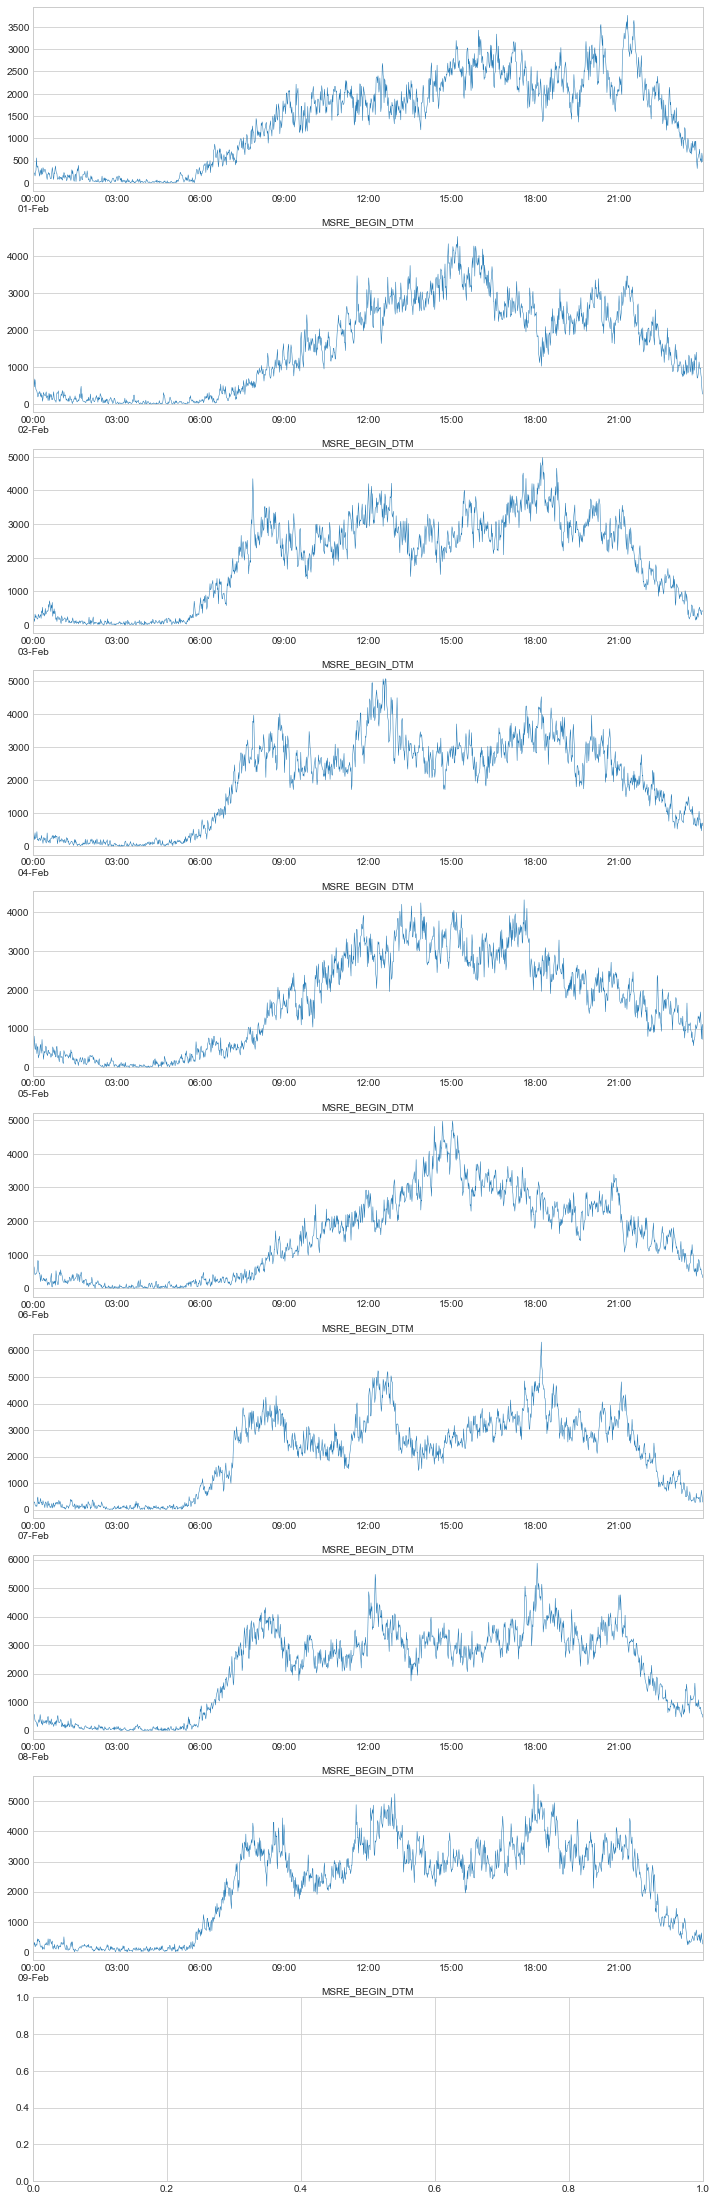

In [83]:
fig, axes = plt.subplots(10, 1,figsize = (12, 40))
for i in range(1, 10):
    date = f'2022-02-0{i}'
    step[['MSRE_BEGIN_DTM', 'STEP_CNT']].set_index('MSRE_BEGIN_DTM').resample('1min').sum()['STEP_CNT'].\
                loc[date].plot(ax = axes[i-1], linewidth = 0.5)

In [83]:
step.to_csv('lifelog/GB_SLEEP_HIST_processed.csv', index = False)